# Zillow Final Report

## Goal:

* Discover variables contributing to property value for Zillow
* Utilize these drivers to develop a regression machine learning model to predict property value
* The information derived from this model can subsequently be used on data from new property transactions to predict value

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures

import wrangle
from wrangle import get_zillow_data
from wrangle import wrangle_zillow
from wrangle import split_data

import warnings
warnings.filterwarnings("ignore")

## Acquire

* Data was acquired from the codeup database's Zillow dataset
* Data originally contained 2,152,863 rows and 9 columns before cleaning
* Each row represents a single family home transaction in 2017 in Orange, Los Angeles, and Ventura Counties in       California per the FCC website
* Each column represents a feature of those homes

## Prepare

* Checked for null values, removed rows with null values
* Checked column data types
* Encoded fips categorical variable (county code)
* split data into train, validate, and test (60/20/20)
* no outliers removed for this iteration of the project

In [2]:
# acquire and prepare data
df = wrangle_zillow()

In [3]:
# splits data into train, validate, and test sets
train, validate, test = split_data(df, random_state=7)

In [4]:
# splits into x and y for features and target variable on train, test, and validate
X_train, y_train = train.drop(columns=['id', 'taxvaluedollarcnt', 'fips']), \
train[['taxvaluedollarcnt']]
X_val, y_val = validate.drop(columns=['id', 'taxvaluedollarcnt', 'fips']), \
validate[['taxvaluedollarcnt']]
X_test, y_test = test.drop(columns=['id', 'taxvaluedollarcnt', 'fips']), \
test[['taxvaluedollarcnt']]

In [5]:
y_train.head()

,taxvaluedollarcnt
743746,623774.0
1593028,272000.0
1884457,61004.0
542040,254855.0
2135754,1097000.0


## Data Dictionary 

The following dictionary only defines columns used in analysis for this dataset.

| Feature | Definition |
|:--------|:-----------|
|Tax Value| Dollar value of property sold in 2017|
|Tax Amount| Taxes, in dollars, previously paid on property|
|Year Built| Year property was built|
|Square Feet| Total square footage of property|
|Bedrooms| Number of bedrooms|
|Bathrooms| Number of bathrooms. Partial means no washing facility, only toilet|
|FIPS| Federal Information Processing Standards, categorical variable of county codes for above counties|


### View of the data

In [6]:
df.head().T

,4,6,7,11,14
id,20,31,33,62,97
bedroomcnt,4.0,3.0,3.0,0.0,0.0
bathroomcnt,2.0,4.0,2.0,0.0,0.0
calculatedfinishedsquarefeet,3633.0,1620.0,2077.0,1200.0,171.0
taxvaluedollarcnt,296425.0,847770.0,646760.0,5328.0,6920.0
yearbuilt,2005.0,2011.0,1926.0,1972.0,1973.0
taxamount,6941.39,10244.94,7924.68,91.6,255.17
fips,6037.0,6037.0,6037.0,6037.0,6037.0
fips_6059.0,0,0,0,0,0
fips_6111.0,0,0,0,0,0


### Summary of the data

In [7]:
df.describe()

,id,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips_6059.0,fips_6111.0
count,2.140235e+06,2.140235e+06,2.140235e+06,2.140235e+06,2.140235e+06,2.140235e+06,2.140235e+06,2.140235e+06,2.140235e+06
mean,1.490823e+06,3.301419e+00,2.240352e+00,1.863194e+03,4.606416e+05,1.960968e+03,5.616711e+03,2.579422e-01,7.614631e-02
std,8.608367e+05,9.325998e-01,9.905489e-01,1.221754e+03,6.771576e+05,2.215056e+01,7.814563e+03,4.375021e-01,2.652321e-01
min,2.000000e+01,0.000000e+00,0.000000e+00,1.000000e+00,2.200000e+01,1.801000e+03,6.340000e+00,0.000000e+00,0.000000e+00
25%,7.452520e+05,3.000000e+00,2.000000e+00,1.258000e+03,1.891660e+05,1.949000e+03,2.540850e+03,0.000000e+00,0.000000e+00
50%,1.490470e+06,3.000000e+00,2.000000e+00,1.623000e+03,3.282960e+05,1.958000e+03,4.111470e+03,0.000000e+00,0.000000e+00
75%,2.235778e+06,4.000000e+00,3.000000e+00,2.208000e+03,5.346060e+05,1.976000e+03,6.411930e+03,1.000000e+00,0.000000e+00
max,2.982282e+06,2.500000e+01,3.200000e+01,9.525760e+05,9.018846e+07,2.016000e+03,1.078102e+06,1.000000e+00,1.000000e+00


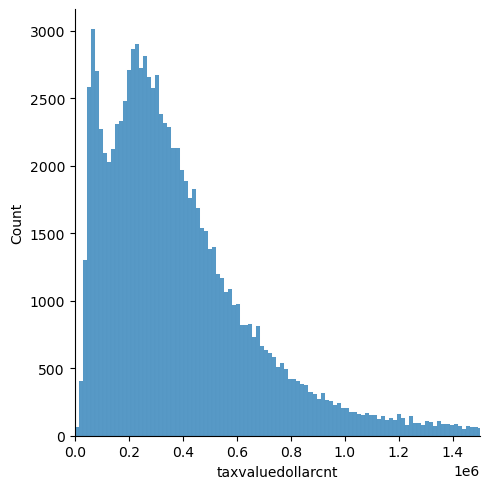

In [8]:
sns.displot(data=test.sample(100000), x='taxvaluedollarcnt')
plt.xlim(0, 1500000)
plt.show()

## Explore 

 Alpha for all statistical tests is .05

### Which variable is most strongly correlated with home value?

In [9]:
# this creates spearman correlation coefficients between each variable in the data
exam_corr = train.corr(method='spearman')
exam_corr

,id,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips_6059.0,fips_6111.0
id,1.000000,0.001132,-0.000516,-0.000503,-0.000316,0.001923,-0.000051,0.004168,-0.002630
bedroomcnt,0.001132,1.000000,0.634089,0.655521,0.295796,0.426032,0.297101,0.134474,0.092787
bathroomcnt,-0.000516,0.634089,1.000000,0.825958,0.482003,0.570264,0.481531,0.166368,0.064681
calculatedfinishedsquarefeet,-0.000503,0.655521,0.825958,1.000000,0.523148,0.511772,0.520477,0.161795,0.070704
taxvaluedollarcnt,-0.000316,0.295796,0.482003,0.523148,1.000000,0.290896,0.978736,0.148174,0.037879
yearbuilt,0.001923,0.426032,0.570264,0.511772,0.290896,1.000000,0.289409,0.332884,0.188305
taxamount,-0.000051,0.297101,0.481531,0.520477,0.978736,0.289409,1.000000,0.099325,0.004249
fips_6059.0,0.004168,0.134474,0.166368,0.161795,0.148174,0.332884,0.099325,1.000000,-0.169215
fips_6111.0,-0.002630,0.092787,0.064681,0.070704,0.037879,0.188305,0.004249,-0.169215,1.000000


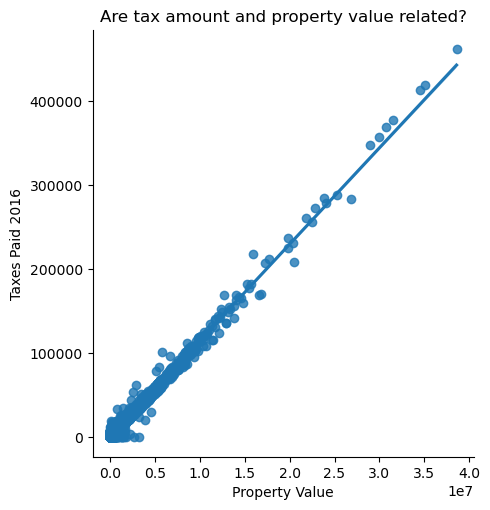

In [10]:
# this creates a plot showing a sample of points and a regression line between value and tax amount
sns.lmplot(x='taxvaluedollarcnt', y='taxamount', data=train.sample(100000)).set(title='Are tax amount and property value related?')
plt.xlabel('Property Value')
plt.ylabel('Taxes Paid 2016')
plt.show()

* Tax amount appears extremely highly correlated with property value
* This makes sense logically

### How closely are the variables potentially affecting value related to each other?

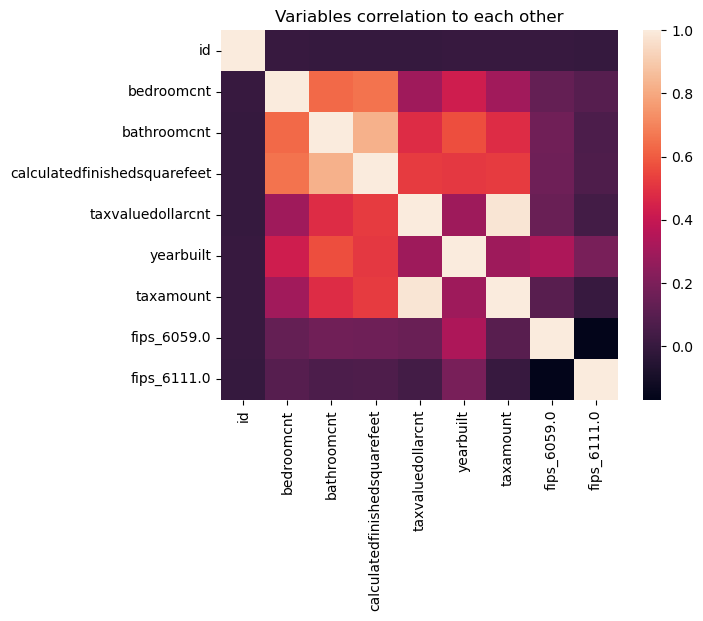

In [11]:
# this creates a heatmap showing correlation between all variables in the dataframe
sns.heatmap(exam_corr).set(title='Variables correlation to each other')
plt.show()

* Square footage, bedroom count, and bathroom count are all relatively correlated to each other
* This also makes logical sense

### How closely are bedroom count and bathroom count related? 

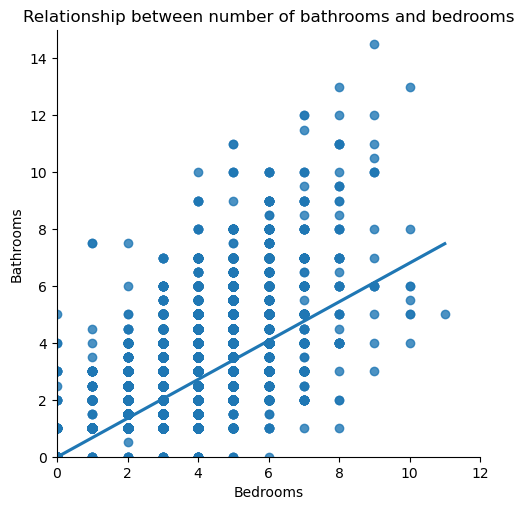

In [12]:
# this plots, with labels, bedroom and bathroom counts
sns.lmplot(x='bedroomcnt', y='bathroomcnt', data=train.sample(100000)).set(title='Relationship between number of bathrooms and bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Bathrooms')
plt.xlim(0, 12)
plt.ylim(0, 15)
plt.show()

Ho: Bedrooms and bathrooms and not statistically significantly correlated
Ha: Bedrooms and bathrooms are statistically significantly related

In [13]:
# this runs a spearman test to determine if there is a statistically significant correlation
r,p = spearmanr(train.bedroomcnt, train.bathroomcnt)
r,p

(0.6340887436870352, 0.0)

* Bedrooms and bathrooms are statistically significantly related and, per above, this is likely all related to square footage

### What drives differences in value between counties?

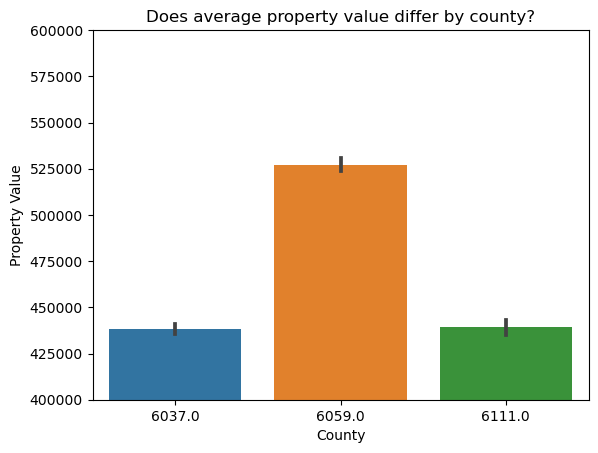

In [14]:
# This creates a plot comparing means of property value between counties
sns.barplot(x='fips', y='taxvaluedollarcnt', data=test).set(title='Does average property value differ by county?')
plt.xlabel('County')
plt.ylabel('Property Value')
plt.ylim(400000, 600000)
plt.show()

In [15]:
# this 
orange_county = test[test.fips == 6059.0].taxvaluedollarcnt
los_angeles = test[test.fips == 6037.0].taxvaluedollarcnt
ventura_county = test[test.fips == 6111.0].taxvaluedollarcnt


In [16]:
# this runs a kriskal Wallis test to determine statistically significant difference in means property 
# value between counties
f, p = stats.kruskal(orange_county, los_angeles, ventura_county)
f, p

(10844.36365127075, 0.0)

In [17]:

def plot_fips(train):
        sns.barplot(x='fips', y='taxamount', data=train).set(title='Do any variables indicate why Orange County has higher average property value?')
        plt.xlabel('County Code')
        plt.ylabel('2016 Property Taxes')
        plt.show()
        sns.barplot(x='fips', y='bathroomcnt', data=train)
        plt.xlabel('County Code')
        plt.ylabel('Bathrooms')
        plt.show()
        sns.barplot(x='fips', y='calculatedfinishedsquarefeet', data=train)
        plt.xlabel('County Code')
        plt.ylabel('Square Footage')
        plt.show()
        sns.barplot(x='fips', y='bedroomcnt', data=train)
        plt.xlabel('County Code')
        plt.ylabel('Bedrooms')
        plt.show()
        sns.barplot(x='fips', y='yearbuilt', data=train)
        plt.xlabel('County Code')
        plt.ylabel('Year Built')
        plt.ylim(1900, 2017)
        plt.show()

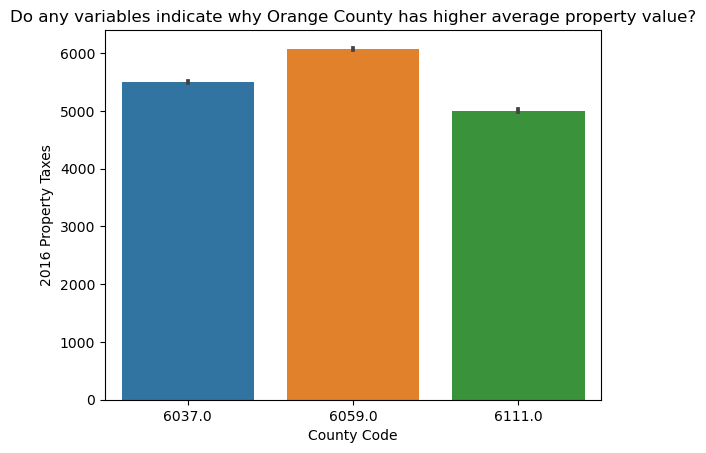

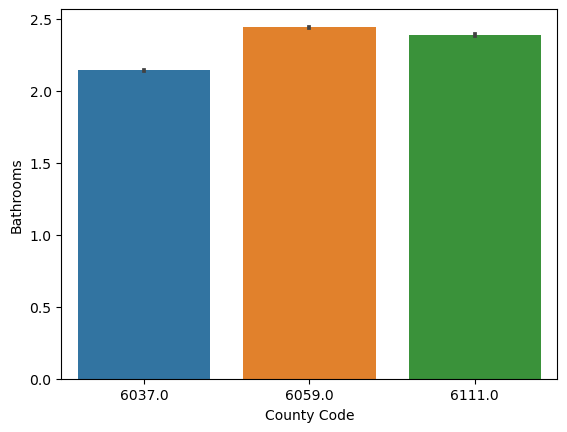

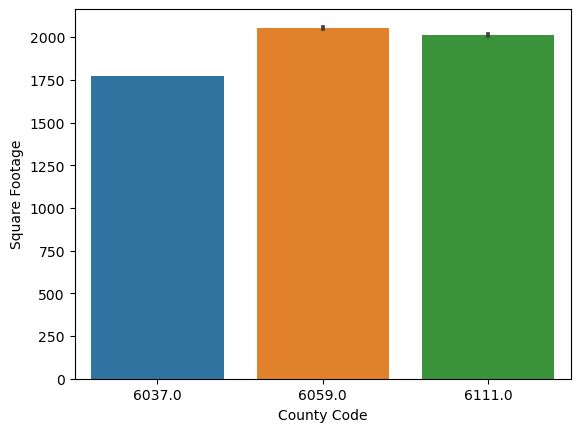

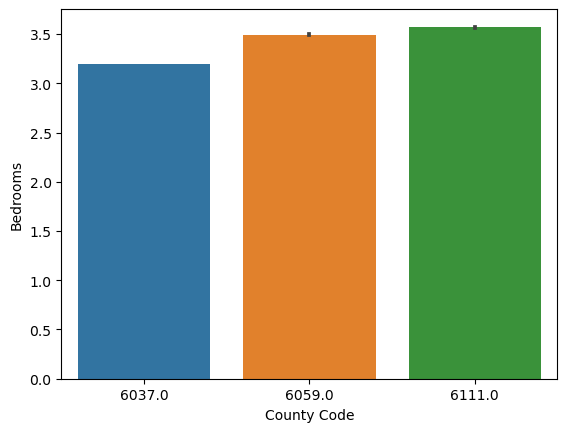

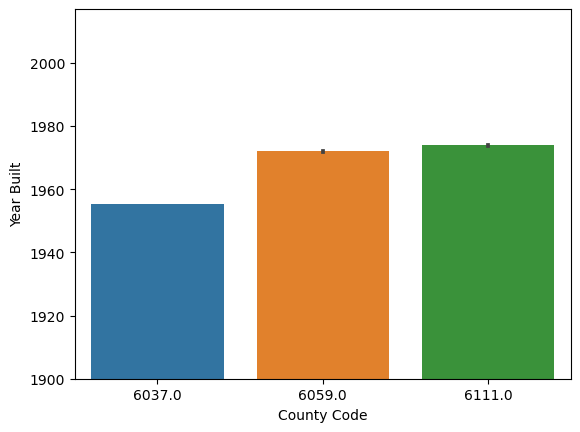

In [18]:
plot_fips(train)

* No single variable accounts for difference in average property value between Orange County and the others

### Exploration Summary

* Numerous variables are related to each other
* No single variable accounts for differences between counties
* We will likely need to use algorithmic techniques to pick our most useful variables

## Creating a Predictive Model

* We will use Root of Mean Squared Error as the primary method to evaluate efficacy of our model due to its ease of intepretability
* We will use simple linear regression with different numbers of algorithmic best values

In [19]:
# this scales our train data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [20]:
# this creates a dataframe from the scaled data
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

In [21]:
# this creates dataframes for validate and test data
X_val_scaled = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

### Find top 5 variables

In [22]:
# selects algorithimc 5 best variables
best5 = SelectKBest(f_regression, k=5)
best5.fit(X_train, y_train)

SelectKBest(k=5, score_func=<function f_regression at 0x133fc6b90>)

In [23]:
# puts these variables into X_train columns
X_train.columns[best5.get_support()]

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'yearbuilt', 'taxamount'],
      dtype='object')

In [24]:
# creates column of best 5 variables
k_columns5 = X_train.columns[best5.get_support()].to_list()

### Find top 4 variables

In [25]:
# picks algorithm based 4 best variables
best4 = SelectKBest(f_regression, k=4)
best4.fit(X_train, y_train)

SelectKBest(k=4, score_func=<function f_regression at 0x133fc6b90>)

In [26]:
# puts these into X_train
X_train.columns[best4.get_support()]

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'taxamount'],
      dtype='object')

In [27]:
#Creates column of best variables
k_columns4 = X_train.columns[best4.get_support()].to_list()

### Find top 3 variables

In [28]:
# picks top 3 variables
best3 = SelectKBest(f_regression, k=3)
best3.fit(X_train_scaled, y_train)

SelectKBest(k=3, score_func=<function f_regression at 0x133fc6b90>)

In [29]:
# puts them into dataframe
X_train.columns[best3.get_support()]

Index(['bathroomcnt', 'calculatedfinishedsquarefeet', 'taxamount'], dtype='object')

In [30]:
# puts them into column
k_columns3 = X_train.columns[best3.get_support()].to_list()

### Establish baseline

In [31]:
# this sets mean and median of y_train as baseline mean and median
y_train['baseline_mean'] = y_train.taxvaluedollarcnt.mean()
y_train['baseline_median'] = y_train.taxvaluedollarcnt.median()

rmse_mean = mean_squared_error(y_train.taxvaluedollarcnt,
                               y_train['baseline_mean'], squared=False)
rmse_med = mean_squared_error(y_train.taxvaluedollarcnt,
                               y_train['baseline_median'], squared=False)

rmse_mean, rmse_med

(672548.8985045213, 685328.6734242525)

In [32]:
# puts mean into validate 
y_val['baseline_mean'] = y_train['taxvaluedollarcnt'].mean()

In [33]:
# sets up dataframe for evaluation ouput
metric_df = pd.DataFrame(
[
    {
        'model': 'baseline_mean',
        'rmse': mean_squared_error(y_val['taxvaluedollarcnt'], y_val.baseline_mean),
        'r^2': explained_variance_score(y_val['taxvaluedollarcnt'], y_val.baseline_mean)
    
    }
])

In [34]:
def model_metrics(model, 
                  X_train, 
                  y_train, 
                  X_val, 
                  y_val, 
                  scores=metric_df):
    '''
    this function will utilize an object to 
    predict target values after fitting to train set, 
    score model, and add resulting scores to metric_df
    returns: metric_df
    '''
    # fit object
    model.fit(X_train, y_train['taxvaluedollarcnt'])
    in_sample_pred = model.predict(X_train)
    out_sample_pred = model.predict(X_val)
    model_name = input('Name for model? python identifer friendly pls.\n')
    y_train[model_name] = in_sample_pred
    y_val[model_name] = out_sample_pred
    print(y_val.shape)
    print(out_sample_pred.shape)
    rmse_val = mean_squared_error(
    y_val['taxvaluedollarcnt'], out_sample_pred, squared=False)
    r_squared_val = explained_variance_score(
        y_val['taxvaluedollarcnt'], out_sample_pred)
    return metric_df.append({
        'model': model_name,
        'rmse': rmse_val,
        'r^2': r_squared_val
    
    }, ignore_index=True)


In [35]:
# sets and puts baseline model into dataframe
metric_df = model_metrics(LinearRegression(), 
                  X_train_scaled, 
                  y_train, 
                  X_val_scaled, 
                  y_val, 
                  scores=metric_df)

Name for model? python identifer friendly pls.
baseline
(428047, 3)
(428047,)


In [36]:
# top 5 features model
metric_df = model_metrics(LinearRegression(), 
                  X_train_scaled[k_columns5], 
                  y_train, 
                  X_val_scaled[k_columns5], 
                  y_val, 
                  scores=metric_df)


Name for model? python identifer friendly pls.
Top_5_regression
(428047, 4)
(428047,)


In [37]:
# top 4
metric_df = model_metrics(LinearRegression(), 
                  X_train_scaled[k_columns4], 
                  y_train, 
                  X_val_scaled[k_columns4], 
                  y_val, 
                  scores=metric_df)


Name for model? python identifer friendly pls.
Top_4_regression
(428047, 5)
(428047,)


In [38]:
# top 3
metric_df = model_metrics(LinearRegression(), 
                  X_train_scaled[k_columns3], 
                  y_train, 
                  X_val_scaled[k_columns3], 
                  y_val, 
                  scores=metric_df)

Name for model? python identifer friendly pls.
Top_3_regression
(428047, 6)
(428047,)


In [39]:
# polynomial model
polyfeats = PolynomialFeatures(degree=2)
X_train_quad = polyfeats.fit_transform(X_train_scaled)
X_val_quad = polyfeats.transform(X_val_scaled)
metric_df = model_metrics(LinearRegression(), 
                  X_train_quad, 
                  y_train, 
                  X_val_quad, 
                  y_val, 
                  scores=metric_df)

Name for model? python identifer friendly pls.
Polynomial
(428047, 7)
(428047,)


In [40]:
metric_df

,model,rmse,r^2
0,baseline_mean,4.702939e+11,0.000000
1,baseline,8.975183e+04,0.982872
2,Top_5_regression,9.222204e+04,0.981916
3,Top_4_regression,9.224664e+04,0.981906
4,Top_3_regression,9.226696e+04,0.981898
5,Polynomial,8.627177e+04,0.984174


In [41]:
# compares with test data
polyfeats = PolynomialFeatures(degree=2)
X_train_quad = polyfeats.fit_transform(X_train_scaled)
X_test_quad = polyfeats.transform(X_test_scaled)
metric_df = model_metrics(LinearRegression(), 
                  X_train_quad, 
                  y_train, 
                  X_train_quad, 
                  y_train, 
                  scores=metric_df)

Name for model? python identifer friendly pls.
Test
(1284141, 9)
(1284141,)


In [42]:
metric_df

,model,rmse,r^2
0,baseline_mean,4.702939e+11,0.000000
1,baseline,8.975183e+04,0.982872
2,Top_5_regression,9.222204e+04,0.981916
3,Top_4_regression,9.224664e+04,0.981906
4,Top_3_regression,9.226696e+04,0.981898
5,Polynomial,8.627177e+04,0.984174
6,Test,7.896168e+04,0.986216


## Conclusions

### Exploration

* Tax Amount is the variable most closely correlated with Value
* A number of variables are interrelated
* Differences in average value between counties require examination of multiple variables

### Modeling

* Model does not outperform baseline
* Additional model types should be examined 

### Recommendations

* Focus any future models around tax value
* Focus on selling on Orange County

### Next Steps

* Add more variables to model
* Modify polynomial parameters to increasing powers
* Combine bedrooms and bathrooms into 1 category